<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C4/C4.html"><img src="../data/C4_nav.png" width="100"  style="float:right;" alt="C4"></a>
<h1>SSM: Thresholding</h1> 
</div>

<br/>

<p>
Following Section 4.2.2.4 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we discuss in this notebook thresholding strategies that are applicable for a wide range of matrix representations. We show the behavior of these strategies by applying them to self-similarity matrices. The functionalities are also provided by the MATLAB toolbox described in the following article:

<ul>
<li><span style="color:black">
Meinard Müller, Nanzhu Jiang, and Harald Grohganz: <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller/publications/2014_MuellerJiangGrohganz_ToolboxSM_AES.pdf"><strong>SM Toolbox: MATLAB implementations for computing and enhancing similarity matrices.</strong></a> Proceedings of the 53rd AES Conference on Semantic Audio, London, UK, 2014.
<br>    
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_MuellerJG14_SM-Toolbox_AES.txt"> Bibtex </a>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="https://www.audiolabs-erlangen.de/resources/MIR/SMtoolbox">MATLAB Toolbox</a>
</span></li>
</ul>    
</p> 

## Introduction

In many music analysis applications, self-similarity matrices are further processed by suppressing all values that fall below a given threshold. On the one hand, such a step often leads to a substantial reduction of unwanted noise-like components while leaving only the most significant structures. On the other hand, weaker but still relevant information may be lost. The thresholding strategy used may have a significant impact on the final result and has to be carefully chosen in the context of the considered application. In this notebook, we introduce different thresholding techniques that are applicable to **any real-valued matrix with nonnegative entries**. For the moment, before we come back to our SSM scenario, let $\mathbf{S}\in\mathbb{R}_{\geq 0}^{N\times M}$ be such a matrix having dimensions $N,M\in\mathbb{N}$. As illustration, we use a small toy example.

In [1]:
import sys
import numpy as np
from matplotlib import pyplot as plt
sys.path.append('..')
import libfmp.b

%matplotlib inline

S = np.array([[8,7,6,5,4,3], [3,4,5,6,7,8], [2,3,4,5,6,7], [1,2,3,4,5,6]])
N, M = S.shape
print('Matrix S of dimension N=%d and M=%d:'%(N,M))
print(S)

Matrix S of dimension N=4 and M=6:
[[8 7 6 5 4 3]
 [3 4 5 6 7 8]
 [2 3 4 5 6 7]
 [1 2 3 4 5 6]]


## Global Thresholding

The simplest strategy is to apply **global thresholding**, where all values $\mathbf{S}(n,m)$ of a matrix $\mathbf{S}\in\mathbb{R}_{\geq 0}^{N\times M}$ below a given threshold parameter $\tau>0$ are set to zero:

\begin{equation}
    \mathbf{S}_\tau(n,m):=\left\{\begin{array}{ll}
    \mathbf{S}(n,m) &\quad \mbox{if $\mathbf{S}(n,m)\geq\tau$,}\\
    0,&\quad\mbox{otherwise.}
\end{array}\right.
\end{equation}

Also, **binarization** of the matrix can be applied by setting all values above or equal to the threshold to one and all others to zero. 

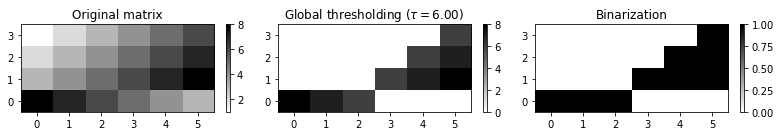

In [2]:
S_global = np.copy(S)

thresh = 6
S_global = np.copy(S)
S_global[S_global < thresh] = 0
S_binary = np.copy(S_global)
S_binary[S_global >= thresh] = 1

figsize=(11, 2)
fig, ax = plt.subplots(1, 3, figsize=figsize)
libfmp.b.plot_matrix(S, ax=[ax[0]], xlabel='', ylabel='',
                     title=r'Original matrix')
libfmp.b.plot_matrix(S_global, ax=[ax[1]], xlabel='', ylabel='',
                     title=r'Global thresholding ($\tau = %0.2f$)'%thresh)
libfmp.b.plot_matrix(S_binary, ax=[ax[2]], xlabel='', ylabel='', 
                     title=r'Binarization')
plt.tight_layout()
plt.show()

## Scaling and  Penalty

Instead of binarization, one may perform a **scaling** where the range $[\tau,\mu]$ is linearly scaled to $[0,1]$ in the case that $\mu:=\max_{n,m}\{\mathbf{S}(n,m)\}>\tau$, otherwise all entries are set to zero.  Sometimes it may be beneficial to introduce an additional **penalty** parameter $\delta\leq 0$, setting all original values below the threshold to the value $\delta$. The following figure shows the result before and after scaling continuing our example above. Furthermore, we apply a penalty parameter $\delta=-2$. The meaning of the penalty parameters becomes important when discussing a procedure for [audio thumbnailing](../C4/C4S3_AudioThumbnailing.html).

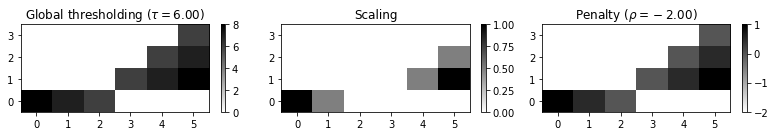

In [3]:
min_value = thresh
max_value = np.max(S_global) 
if max_value > min_value:
    S_scale = np.divide((S_global - min_value), (max_value -  min_value)) 
    S_scale[S_global<thresh] = 0
else:
    raise Exception('Scaling not possible: max > min is violated')    
        
penalty = -2
S_penalty = np.divide((S_global - min_value), (max_value -  min_value)) 
S_penalty[S_global<thresh] = penalty

fig, ax = plt.subplots(1, 3, figsize=figsize)
libfmp.b.plot_matrix(S_global, ax=[ax[0]], xlabel='', ylabel='', 
                     title=r'Global thresholding ($\tau = %0.2f$)'%thresh)
libfmp.b.plot_matrix(S_scale, ax=[ax[1]], xlabel='', ylabel='', 
                     title=r'Scaling')
libfmp.b.plot_matrix(S_penalty, ax=[ax[2]], xlabel='', ylabel='', 
                     title=r'Penalty ($\rho = %0.2f$)'%penalty)
plt.tight_layout()
plt.show()

## Relative Thresholding

The global threshold $\tau$ can also be chosen in a **relative** fashion. Given a relative threshold parameter $\rho\in [0,1]$, the idea is to keep $\rho\cdot 100\%$ of the cells with the highest values. To this ends, one needs to sort the matrix entries according to their values. From the sorted list, one can then determine a global threshold that splits the values according to $\rho$. This relative thresholding strategy is applied in the following example using different relative threshold parameters. 

<div class="alert alert-block alert-warning">
<strong>Important note:</strong> Because of rounding issues and the fact that different matrix entries may have identical values, the split as specified by $\rho$ may not be exact.
</div> 

thresh_rel=0.50, thresh_abs=5, total_num_cells=24, num_cells_below_thresh=12, 
thresh_rel=0.30, thresh_abs=6, total_num_cells=24, num_cells_below_thresh=17, 
thresh_rel=0.10, thresh_abs=8, total_num_cells=24, num_cells_below_thresh=22, 


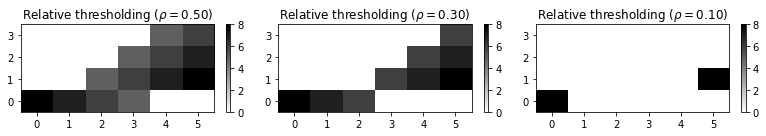

In [4]:
def threshold_matrix_relative(S, thresh_rel=0.2, details=False):
    """Treshold matrix in a relative fashion

    Notebook: C4/C4S2_SSM-Thresholding.ipynb

    Args:
        S (np.ndarray): Input matrix
        thresh_rel (float): Relative treshold (Default value = 0.2)
        details (bool): Print details on thresholding procedure (Default value = False)

    Returns:
        S_thresh (np.ndarray): Thresholded matrix
        thresh_abs (float): Absolute threshold used for thresholding
    """
    S_thresh = np.copy(S)
    num_cells_below_thresh = int(np.round(S_thresh.size*(1-thresh_rel)))
    values_sorted = np.sort(S_thresh.flatten('F'))
    thresh_abs = values_sorted[num_cells_below_thresh]
    S_thresh[S_thresh < thresh_abs] = 0
    if details:
        print('thresh_rel=%0.2f, thresh_abs=%d, total_num_cells=%d, num_cells_below_thresh=%d, ' %
              (thresh_rel, thresh_abs, S_thresh.size, num_cells_below_thresh))
    return S_thresh, thresh_abs


thresh_rel_set = [0.5, 0.3, 0.1]
num = len(thresh_rel_set)
fig, ax = plt.subplots(1, num, figsize=figsize)
for m in range(num):
    thresh_rel = thresh_rel_set[m]
    S_relative, thresh_abs = threshold_matrix_relative(S, thresh_rel, details=True)
    libfmp.b.plot_matrix(S_relative, ax=[ax[m]], xlabel='', ylabel='', 
                         title=r'Relative thresholding ($\rho = %0.2f$)'%thresh_rel)

plt.tight_layout()
plt.show()

## Local Thresholding

Finally, thresholding can also be performed using a more **local** strategy by thresholding in a row- and column-wise fashion. Let $\rho_1\in[0,1]$ be a relative threshold for the rows and $\rho_2\in[0,1]$ for the columns. Then, for each cell $(n,m)$, the value $\mathbf{S}(n,m)$ is kept if it is among the $\rho_1\cdot 100\%$ of the largest cells in row $n$ and at the same time among the $\rho_2\cdot 100\%$ of the largest cells in column $m$, all other values being set to zero. In the following figure, we show two binary masks (as intermediate results) that indicate whether cells belong to the largest among their rows or columns, respectively, as well as the final result.

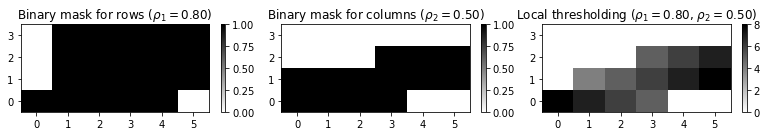

In [5]:
thresh_rel_row=0.8
thresh_rel_col=0.5

S_binary_row = np.ones([N,M])
num_cells_row_below_thresh = int(np.round(M*(1-thresh_rel_row)))
for n in range(N):
    row = S[n,:]
    values_sorted = np.sort(row)
    thresh_abs = values_sorted[num_cells_row_below_thresh]
    S_binary_row[n,:] = (row>=thresh_abs)

S_binary_col = np.ones([N,M])
num_cells_col_below_thresh = int(np.round(N*(1-thresh_rel_col)))  
for m in range(M):
    col = S[:,m]
    values_sorted = np.sort(col)
    thresh_abs = values_sorted[num_cells_col_below_thresh]
    S_binary_col[:,m] = (col>=thresh_abs)
    
S_local =  S * S_binary_row * S_binary_col
    
fig, ax = plt.subplots(1, 3, figsize=figsize)
libfmp.b.plot_matrix(S_binary_row, ax=[ax[0]], xlabel='', ylabel='', 
                     title=r'Binary mask for rows ($\rho_1 = %0.2f$)'%thresh_rel_row)
libfmp.b.plot_matrix(S_binary_col, ax=[ax[1]], xlabel='', ylabel='', 
                     title=r'Binary mask for columns ($\rho_2 = %0.2f$)'%thresh_rel_col)
libfmp.b.plot_matrix(S_local, ax=[ax[2]], xlabel='', ylabel='', 
                     title=r'Local thresholding ($\rho_1 = %0.2f$, $\rho_2 = %0.2f$)'%(thresh_rel_row,thresh_rel_col))
plt.tight_layout()
plt.show()

## Implementation: Thresholding Function

As said before, the suitability of a thresholding setting depends on the respective music material and the application in mind. Often, suitable thresholds are learned and optimized using supervised learning procedures. The following code cell provides the function <code>threshold_matrix</code>, which comprises all the thresholding variants discussed above.

<div class="alert alert-block alert-warning">
<strong>Important notes for the function <code>threshold_matrix</code>:</strong>  
    
* Some parameter settings may not make sense (for exampling, using scaling with penalty as well as binarization). 
* Depending on the strategy, one may need one threshold (in case of <code>'absolute'</code> and <code>'relative'</code>) or two threshold parameters (in case of <code>'local'</code>).
* Because of rounding issues and the fact that different matrix entries may have identical values, the split as specified by $\rho$ may not be exact.     
</div> 

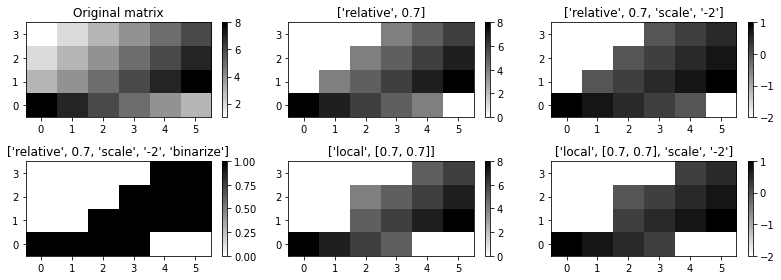

In [6]:
def threshold_matrix(S, thresh, strategy='absolute', scale=False, penalty=0.0, binarize=False):
    """Treshold matrix in a relative fashion

    Notebook: C4/C4S2_SSM-Thresholding.ipynb

    Args:
        S (np.ndarray): Input matrix
        thresh (float or list): Treshold (meaning depends on strategy)
        strategy (str): Thresholding strategy ('absolute', 'relative', 'local') (Default value = 'absolute')
        scale (bool): If scale=True, then scaling of positive values to range [0,1] (Default value = False)
        penalty (float): Set values below treshold to value specified (Default value = 0.0)
        binarize (bool): Binarizes final matrix (positive: 1; otherwise: 0) (Default value = False)

    Returns:
        S_thresh (np.ndarray): Thresholded matrix
    """
    if np.min(S) < 0:
        raise Exception('All entries of the input matrix must be nonnegative')

    S_thresh = np.copy(S)
    N, M = S.shape
    num_cells = N * M

    if strategy == 'absolute':
        thresh_abs = thresh
        S_thresh[S_thresh < thresh] = 0

    if strategy == 'relative':
        thresh_rel = thresh
        num_cells_below_thresh = int(np.round(S_thresh.size*(1-thresh_rel)))
        if num_cells_below_thresh < num_cells:
            values_sorted = np.sort(S_thresh.flatten('F'))
            thresh_abs = values_sorted[num_cells_below_thresh]
            S_thresh[S_thresh < thresh_abs] = 0
        else:
            S_thresh = np.zeros([N, M])

    if strategy == 'local':
        thresh_rel_row = thresh[0]
        thresh_rel_col = thresh[1]
        S_binary_row = np.zeros([N, M])
        num_cells_row_below_thresh = int(np.round(M * (1-thresh_rel_row)))
        for n in range(N):
            row = S[n, :]
            values_sorted = np.sort(row)
            if num_cells_row_below_thresh < M:
                thresh_abs = values_sorted[num_cells_row_below_thresh]
                S_binary_row[n, :] = (row >= thresh_abs)
        S_binary_col = np.zeros([N, M])
        num_cells_col_below_thresh = int(np.round(N * (1-thresh_rel_col)))
        for m in range(M):
            col = S[:, m]
            values_sorted = np.sort(col)
            if num_cells_col_below_thresh < N:
                thresh_abs = values_sorted[num_cells_col_below_thresh]
                S_binary_col[:, m] = (col >= thresh_abs)
        S_thresh = S * S_binary_row * S_binary_col

    if scale:
        cell_val_zero = np.where(S_thresh == 0)
        cell_val_pos = np.where(S_thresh > 0)
        if len(cell_val_pos[0]) == 0:
            min_value = 0
        else:
            min_value = np.min(S_thresh[cell_val_pos])
        max_value = np.max(S_thresh)
        # print('min_value = ', min_value, ', max_value = ', max_value)
        if max_value > min_value:
            S_thresh = np.divide((S_thresh - min_value), (max_value - min_value))
            if len(cell_val_zero[0]) > 0:
                S_thresh[cell_val_zero] = penalty
        else:
            print('Condition max_value > min_value is voliated: output zero matrix')

    if binarize:
        S_thresh[S_thresh > 0] = 1
        S_thresh[S_thresh < 0] = 0
    return S_thresh



figsize=(11, 4)
fig, ax = plt.subplots(2, 3, figsize=figsize)
libfmp.b.plot_matrix(S, ax=[ax[0,0]], xlabel='', ylabel='', title=r'Original matrix')

strategy = 'relative'
thresh = 0.7
S_thresh = threshold_matrix(S, thresh=thresh, strategy=strategy, scale=0, penalty=0, binarize=0)
libfmp.b.plot_matrix(S_thresh, ax=[ax[0,1]], xlabel='', ylabel='', 
                     title=[strategy, thresh])

strategy = 'relative'
thresh = 0.7
S_thresh = threshold_matrix(S, thresh=thresh, strategy=strategy, scale=1, penalty=-2, binarize=0)
libfmp.b.plot_matrix(S_thresh, ax=[ax[0,2]], xlabel='', ylabel='', 
                     title=[strategy, thresh, "scale", "-2"])

strategy = 'relative'
thresh = 0.7
S_thresh = threshold_matrix(S, thresh=thresh, strategy=strategy, scale=1, penalty=-2, binarize=1)
libfmp.b.plot_matrix(S_thresh, ax=[ax[1,0]], xlabel='', ylabel='', 
                     title=[strategy, thresh, "scale", "-2", "binarize"])

strategy = 'local'
thresh = [0.7, 0.7]
S_thresh = threshold_matrix(S, thresh=thresh, strategy=strategy, scale=0, penalty=0, binarize=0)
libfmp.b.plot_matrix(S_thresh, ax=[ax[1,1]], xlabel='', ylabel='', 
                     title=[strategy, thresh])

strategy = 'local'
thresh = [0.7, 0.7]
S_thresh = threshold_matrix(S, thresh=thresh, strategy=strategy, scale=1, penalty=-2, binarize=0)
libfmp.b.plot_matrix(S_thresh, ax=[ax[1,2]], xlabel='', ylabel='', 
                     title=[strategy, thresh, "scale", "-2"])

plt.tight_layout()
plt.show()

## Example: Exercise 4.5

To test our implementation, we consider the toy example from Exercise 4.5 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a> and apply different thresholding operations. Let $\mathbf{S}$ be the matrix defined as:

In [7]:
S = np.array([[1,1,2,2], [4,3,4,3], [1,1,2,2], [5,6,6,5]])
N, M = S.shape
print('Matrix S of dimension N=%d and M=%d:'%(N,M))
print(S)

Matrix S of dimension N=4 and M=4:
[[1 1 2 2]
 [4 3 4 3]
 [1 1 2 2]
 [5 6 6 5]]


$\textbf{(a)}$ Global thresholding using $\tau=4$:

In [8]:
strategy = 'absolute'
thresh = 4
S_thresh = threshold_matrix(S, thresh=thresh, strategy=strategy, scale=0, penalty=0, binarize=0)
print(S_thresh)

[[0 0 0 0]
 [4 0 4 0]
 [0 0 0 0]
 [5 6 6 5]]


$\textbf{(b)}$ Global thresholding using $\tau=4$ as in (a) with subsequent linear scaling of the range $[\tau,\mu]$ to $[0,1]$ using $\mu:=\max\{\mathbf{S}(n,m)\mid n,m \in[1:4]\}$:

In [9]:
strategy = 'absolute'
thresh = 4
S_thresh = threshold_matrix(S, thresh=thresh, strategy=strategy, scale=1, penalty=0, binarize=0)
print(S_thresh)

[[0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.5 1.  1.  0.5]]


$\textbf{(c)}$ Global thresholding with subsequent linear scaling as in (b) and applying the penalty parameter $\delta=-1$:

In [10]:
strategy = 'absolute'
thresh = 4
S_thresh = threshold_matrix(S, thresh=thresh, strategy=strategy, scale=1, penalty=-1, binarize=0)
print(S_thresh)

[[-1.  -1.  -1.  -1. ]
 [ 0.  -1.   0.  -1. ]
 [-1.  -1.  -1.  -1. ]
 [ 0.5  1.   1.   0.5]]


$\textbf{(d)}$ Relative thresholding using the relative threshold parameter $\rho=0.5$:

In [11]:
strategy = 'relative'
thresh = 0.5
S_thresh = threshold_matrix(S, thresh=thresh, strategy=strategy, scale=0, penalty=0, binarize=0)
print(S_thresh)

[[0 0 0 0]
 [4 3 4 3]
 [0 0 0 0]
 [5 6 6 5]]


$\textbf{(e)}$ Local thresholding  in a column- and rowwise fashion using $\rho=0.5$

In [12]:
strategy = 'local'
thresh = [0.5, 0.5]
S_thresh = threshold_matrix(S, thresh=thresh, strategy=strategy, scale=0, penalty=0, binarize=0)
print(S_thresh)

[[0. 0. 0. 0.]
 [4. 0. 4. 0.]
 [0. 0. 0. 0.]
 [0. 6. 6. 0.]]


## Example: Brahms

We now consider a real example by considering the Ormandy recording of the [Hungarian Dance No. 5 by Johannes Brahms](../C4/C4S1_MusicStructureGeneral.html). As a feature representation, we use a [chromagram](../C3/C3S1_SpecLogFreq-Chromagram.html) with a feature resolution of $2~\mathrm{Hz}$. Furthermore, the SSM is processed using [path enhancement techniques](../C4/C4S2_SSM-PathEnhancement.html).

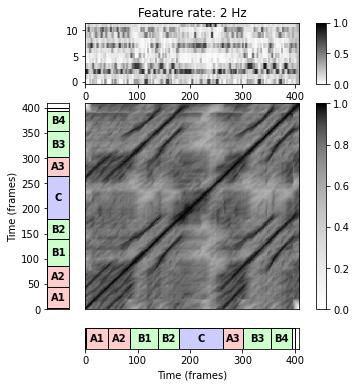

In [13]:
import numpy as np
import os, sys, librosa
from scipy import signal
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
import IPython.display as ipd
import pandas as pd
from numba import jit

sys.path.append('..')
import libfmp.b
import libfmp.c2
import libfmp.c3
import libfmp.c4

%matplotlib inline

def compute_sm_from_filename(fn_wav, L=21, H=5, L_smooth=16, tempo_rel_set=np.array([1]),
                             shift_set=np.array([0]), strategy='relative', scale=True, thresh=0.15,
                             penalty=0.0, binarize=False):
    """Compute an SSM

    Notebook: C4/C4S2_SSM-Thresholding.ipynb

    Args:
        fn_wav (str): Path and filename of wav file
        L (int): Length of smoothing filter (Default value = 21)
        H (int): Downsampling factor (Default value = 5)
        L_smooth (int): Length of filter (Default value = 16)
        tempo_rel_set (np.ndarray):  Set of relative tempo values (Default value = np.array([1]))
        shift_set (np.ndarray): Set of shift indices (Default value = np.array([0]))
        strategy (str): Thresholding strategy (see :func:`libfmp.c4.c4s2_ssm.compute_sm_ti`)
            (Default value = 'relative')
        scale (bool): If scale=True, then scaling of positive values to range [0,1] (Default value = True)
        thresh (float): Treshold (meaning depends on strategy) (Default value = 0.15)
        penalty (float): Set values below treshold to value specified (Default value = 0.0)
        binarize (bool): Binarizes final matrix (positive: 1; otherwise: 0) (Default value = False)

    Returns:
        x (np.ndarray): Audio signal
        x_duration (float): Duration of audio signal (seconds)
        X (np.ndarray): Feature sequence
        Fs_feature (scalar): Feature rate
        S_thresh (np.ndarray): SSM
        I (np.ndarray): Index matrix
    """
    # Waveform
    Fs = 22050
    x, Fs = librosa.load(fn_wav, Fs)
    x_duration = x.shape[0] / Fs

    # Chroma Feature Sequence and SSM (10 Hz)
    C = librosa.feature.chroma_stft(y=x, sr=Fs, tuning=0, norm=2, hop_length=2205, n_fft=4410)
    Fs_C = Fs / 2205

    # Chroma Feature Sequence and SSM
    X, Fs_feature = libfmp.c3.smooth_downsample_feature_sequence(C, Fs_C, filt_len=L, down_sampling=H)
    X = libfmp.c3.normalize_feature_sequence(X, norm='2', threshold=0.001)

    # Compute SSM
    S, I = libfmp.c4.compute_sm_ti(X, X, L=L_smooth, tempo_rel_set=tempo_rel_set, shift_set=shift_set, direction=2)
    S_thresh = libfmp.c4.threshold_matrix(S, thresh=thresh, strategy=strategy,
                                          scale=scale, penalty=penalty, binarize=binarize)
    return x, x_duration, X, Fs_feature, S_thresh, I


# Annotation
filename = 'FMP_C4_Audio_Brahms_HungarianDances-05_Ormandy.csv'
fn_ann = os.path.join('..', 'data', 'C4', filename)
ann, color_ann = libfmp.c4.read_structure_annotation(fn_ann, fn_ann_color=filename)

# SM
fn_wav = os.path.join('..', 'data', 'C4', 'FMP_C4_Audio_Brahms_HungarianDances-05_Ormandy.wav')
tempo_rel_set = libfmp.c4.compute_tempo_rel_set(0.66, 1.5, 5)
x, x_duration, X, Fs_X, S, I = compute_sm_from_filename(fn_wav, L=21, H=5, L_smooth=21, 
                                                        tempo_rel_set=tempo_rel_set, thresh= 1)

# Visualization
ann_frames = libfmp.c4.convert_structure_annotation(ann, Fs=Fs_X) 
fig, ax = libfmp.c4.plot_feature_ssm(X, 1, S, 1, ann_frames, x_duration*Fs_X,
            label='Time (frames)', color_ann=color_ann, clim_X=[0,1], clim=[0,1], 
            title='Feature rate: %0.0f Hz'%(Fs_X))

<audio style="width: 320px;" src="../data/C4/FMP_C4_Audio_Brahms_HungarianDances-05_Ormandy.mp3" type="audio/mpeg" controls="controls"></audio>

In the following code cell, we apply relative and local thresholding variants using different relative threshold parameters. Having a look at the figure, one may observe that the local variants tend to be a bit stricter than the relative ones.

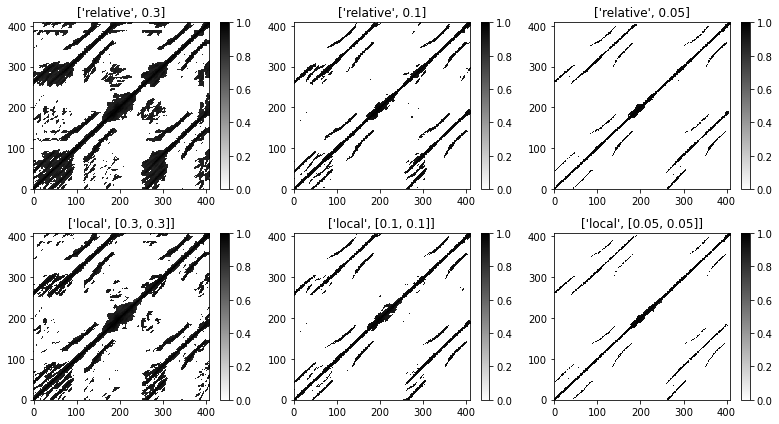

In [14]:
figsize=(11,6)

thresh_set = [0.3, 0.1, 0.05]
strategy_set = ['relative', 'local']
num_t = len(thresh_set)
num_s = len(strategy_set)
fig, ax = plt.subplots(num_s, num_t, figsize=figsize)
for s in range(num_s):
    for t in range(num_t):
        thresh = thresh_set[t]
        strategy = strategy_set[s]
        if strategy == 'local':
            thresh = [thresh, thresh]
        S_thresh = threshold_matrix(S, thresh=thresh, strategy=strategy)
        libfmp.b.plot_matrix(S_thresh, ax=[ax[s,t]], xlabel='', ylabel='', 
                             title=[strategy, thresh])
plt.tight_layout()
plt.show()

## Example: In the Year 2525

We finally consider the song "In the Year 2525" by Zager and Evans, which we used as our running example in the [FMP notebook on transposition-invariant SSMs](../C4/C4S2_SSM-TranspositionInvariance.html). Again, a [chromagram](../C3/C3S1_SpecLogFreq-Chromagram.html) as feature representation with a resolution of $2~\mathrm{Hz}$. To compute the the SSM we apply [path enhancement](../C4/C4S2_SSM-PathEnhancement.html) and [transposition invariance](../C4/C4S2_SSM-TranspositionInvariance.html).

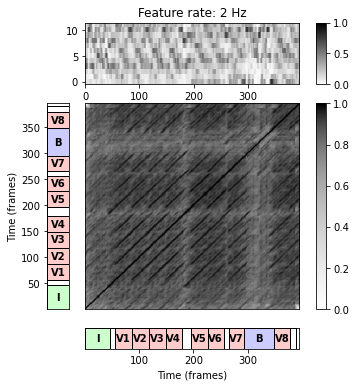

In [15]:
# Annotation
filename = 'FMP_C4_F13_ZagerEvans_InTheYear2525.csv'
fn_ann = os.path.join('..', 'data', 'C4', filename)
ann, color_ann = libfmp.c4.read_structure_annotation(fn_ann, fn_ann_color=filename)

# SM
fn_wav = os.path.join('..', 'data', 'C4', 'FMP_C4_F13_ZagerEvans_InTheYear2525.wav')
shift_set = np.array(range(12))
x, x_duration, X, Fs_X, S, I = compute_sm_from_filename(fn_wav, L=21, H=5, L_smooth=11, 
                                                       shift_set=shift_set, thresh= 1)
# Visualization
ann_frames = libfmp.c4.convert_structure_annotation(ann, Fs=Fs_X) 
fig, ax = libfmp.c4.plot_feature_ssm(X, 1, S, 1, ann_frames, x_duration*Fs_X,
            label='Time (frames)', color_ann=color_ann, clim_X=[0,1], clim=[0,1], 
            title='Feature rate: %0.0f Hz'%(Fs_X))

<audio style="width: 320px;" src="../data/C4/FMP_C4_F13_ZagerEvans_InTheYear2525.mp3" type="audio/mpeg" controls="controls"></audio>

As for the Brahms example, we now apply relative and local thresholding variants using different relative threshold parameters. Note that, since there are more path relations for the song "In the Year 2525" (compared to the Brahms example), using smaller threshold parameters results in a loss of relevant path structures.

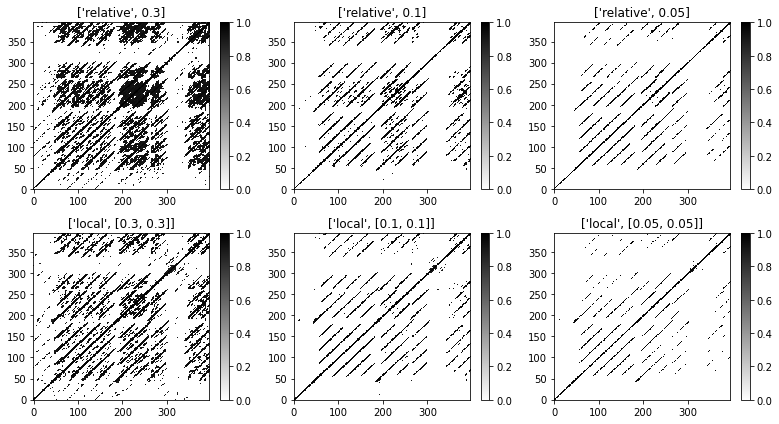

In [16]:
figsize=(11,6)

thresh_set = [0.3, 0.1, 0.05]
strategy_set = ['relative', 'local']
num_t = len(thresh_set)
num_s = len(strategy_set)
fig, ax = plt.subplots(num_s, num_t, figsize=figsize)
for s in range(num_s):
    for t in range(num_t):
        thresh = thresh_set[t]
        strategy = strategy_set[s]
        if strategy == 'local':
            thresh = [thresh, thresh]
        S_thresh = threshold_matrix(S, thresh=thresh, strategy=strategy)
        libfmp.b.plot_matrix(S_thresh, ax=[ax[s,t]], xlabel='', ylabel='', 
                             title=[strategy, thresh])
plt.tight_layout()
plt.show()

We close this notebook with a visualization, where a thresholded SSM is plotted on top of the [transposition index matrix](../C4/C4S2_SSM-TranspositionInvariance.html).

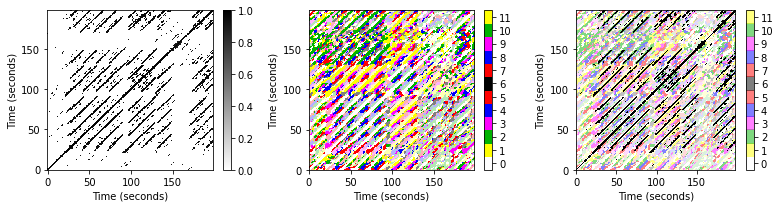

In [17]:
S_thresh = threshold_matrix(S, thresh=[0.2,0.2], strategy='local')

figsize=(11,3)
fig, ax = plt.subplots(1, 3, figsize=figsize)
libfmp.b.plot_matrix(S_thresh, ax=[ax[0]], Fs=Fs_X, Fs_F=Fs_X, ylabel='Time (seconds)')

libfmp.c4.subplot_matrix_ti_colorbar(I, fig, Fs=Fs_X, ax=ax[1], ind_zero=True)

im = libfmp.c4.subplot_matrix_ti_colorbar(I, fig, ax=ax[2], ind_zero=True, Fs=Fs_X, alpha=0.5)
colorList = np.array([[1,1,1,0],[0,0,0,1]])
cmap = ListedColormap(colorList)  
plt.imshow(S_thresh, cmap=cmap, origin = 'lower', 
           extent=[0, S_thresh.shape[0]/Fs_X, 0, S_thresh.shape[0]/Fs_X])
plt.tight_layout()
plt.show()        

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a> and David Kopyto.
</div> 

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>